=== Specs ===
Name: NVIDIA RTX A6000
SM Count: 84
Device Memory: 49139 MB

=== Testing 512x512 Matrix ===
triton_output_with_fp16_inputs=tensor([[  6.8047,  12.1562, -19.9688,  ..., -16.0156,  -3.0488, -38.3750],
        [-18.5469,  -1.1494,   8.9531,  ..., -45.0938, -18.7188, -17.2031],
        [ -0.7622, -13.5469, -29.9531,  ...,  29.8438, -36.5625, -13.7344],
        ...,
        [ 24.4688,  28.5781, -12.0078,  ...,   3.8535, -31.1094, -13.5156],
        [ 47.8125,  13.1797,  14.1797,  ...,  37.1562,  48.3438,   6.3945],
        [-36.7188,  32.2500, -18.8594,  ...,   0.4434, -13.3828,  16.6719]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[  6.8047,  12.1562, -19.9688,  ..., -16.0156,  -3.0488, -38.3750],
        [-18.5469,  -1.1494,   8.9531,  ..., -45.0938, -18.7188, -17.2031],
        [ -0.7622, -13.5469, -29.9531,  ...,  29.8438, -36.5625, -13.7344],
        ...,
        [ 24.4688,  28.5781, -12.0078,  ...,   3.8535, -31.1094, -13.5156],
 

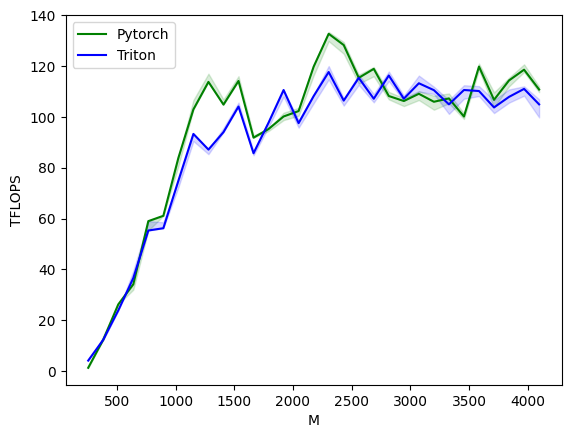

matmul-fp16-performance:
         M       N       K     Pytorch      Triton
0    256.0   256.0   256.0    1.260308    4.096000
1    384.0   384.0   384.0   12.288000   12.288000
2    512.0   512.0   512.0   26.214401   23.831273
3    640.0   640.0   640.0   34.133334   36.571428
4    768.0   768.0   768.0   58.982401   55.296000
5    896.0   896.0   896.0   61.083825   56.197121
6   1024.0  1024.0  1024.0   83.886082   74.898285
7   1152.0  1152.0  1152.0  102.964963   93.312000
8   1280.0  1280.0  1280.0  113.777774   87.148934
9   1408.0  1408.0  1408.0  104.841847   93.996136
10  1536.0  1536.0  1536.0  114.159485  104.086586
11  1664.0  1664.0  1664.0   91.825636   85.703924
12  1792.0  1792.0  1792.0   95.249353   97.734120
13  1920.0  1920.0  1920.0  100.173911  110.591995
14  2048.0  2048.0  2048.0  102.300099   97.541953
15  2176.0  2176.0  2176.0  119.783620  108.191653
16  2304.0  2304.0  2304.0  132.710398  117.674244
17  2432.0  2432.0  2432.0  128.285227  106.418423
18  25

In [10]:
import torch
import triton
 
import triton.language as tl
 
DEVICE = torch.device("cuda:0")
 
configs = [
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
    triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
    triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
    triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
    triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    ]
 
@triton.autotune(
    configs=configs,
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        a_ptr, # (M, K)
        b_ptr, # (K, N)
        c_ptr, # (M, N)
        M, N, K,
        # dimensions for SRAM blocktiles
        BLOCK_SIZE_M: tl.constexpr, 
        BLOCK_SIZE_N: tl.constexpr, 
        BLOCK_SIZE_K: tl.constexpr, 
        GROUP_SIZE_M: tl.constexpr, 
        ACTIVATION: tl.constexpr
):
    pid = tl.program_id(axis=0)
    # each program computes one output tile of shape: BM × BN
    # pid_m: which output row tile to compute
    # pid_n: which output column tile to compute
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    # a group takes some rows and all columns
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    # the m of the first pid in a group
    first_pid_m = group_id * GROUP_SIZE_M
    # while GROUP_SIZE_M is the desired size
    # for the rows-group-tiles at the end, we launch less blocks
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    # we use column major, to optimize L2 cache usage for each k-block:
    # because CUDA often schedules spatially-near blocks to run closely in time,
    #                       block id within group     column major
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m
 
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M))
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N))
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * K + offs_k[None, :])
    # stride_ak is 1 - that is what .is_contiguous() checks for 2D tensors
    b_ptrs = b_ptr + (offs_k[:, None] * N + offs_bn[None, :])
    # same for stride_bn
 
    mask_am = offs_am[:, None] < M 
    mask_bn = offs_bn[None, :] < N
 
    # accumulates in f32 then cast back to f16 (for accuracy)
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K), num_stages=3):
        mask_ak = offs_k[None, :] < K - k * BLOCK_SIZE_K
        mask_bk = offs_k[:, None] < K - k * BLOCK_SIZE_K
        a = tl.load(a_ptrs, mask=(mask_am & mask_ak), other=0.0)
        b = tl.load(b_ptrs, mask=(mask_bn & mask_bk), other=0.0)
        # tl.dot accepts an accumulator
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs += BLOCK_SIZE_K
        b_ptrs += BLOCK_SIZE_K * N
    # operations can be fused here
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)
 
    # writing back
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + M * offs_cm[:, None] + offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)
 
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)
 
def matmul(a, b, activation=""):
    M, K = a.shape
    K, N = b.shape
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        ACTIVATION=activation
    )
    return c
 
def test_triton_matmul():
    torch.manual_seed(4)
    a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    triton_output = matmul(a, b)
    torch_output = torch.matmul(a, b)
    print(f"triton_output_with_fp16_inputs={triton_output}")
    print(f"torch_output_with_fp16_inputs={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=1e-2):
        print("Pass: match")
    else:
        print("Fail: differ")
 
 
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],
        x_vals=[128 * i for i in range(2, 33)],
        line_arg="provider",
        line_vals=['pytorch', "triton"],
        line_names=['Pytorch', "Triton"],
        styles=[("green", "-"), ("blue", "-")],
        ylabel="TFLOPS",
        plot_name="matmul-fp16-performance",
        args={}
    ))
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'pytorch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)
 
if __name__ == "__main__":
    print("=== Specs ===")
    specs = torch.cuda.get_device_properties(DEVICE)
    print("Name:", specs.name)
    print("SM Count:", specs.multi_processor_count)
    print("Device Memory:", specs.total_memory // (1024 ** 2), "MB")
    print("\n=== Testing 512x512 Matrix ===")
    test_triton_matmul()
    print("\n=== Running Benchmark ===")
    benchmark.run(show_plots=True, print_data=True)